In [1]:
# import libraries
import os
from os import listdir
import pandas as pd
import numpy as np
from numpy import asarray
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt
import cv2

Using TensorFlow backend.


# FIRST TASK: CLASSIFY FACES FROM NONE FACES

In [2]:
# image dataset path
dataset = 'faceornot/'

In [3]:
# check image names
for picture in listdir(dataset) :
     if picture != 'Thumbs.db':
            print(picture)#print(picture[0])
            

face_1.JPG
face_10.jpg
face_11.jpg
face_12.jpg
face_13.jpg
face_14.jpg
face_15.jpg
face_16.jpg
face_17.jpg
face_18.jpg
face_19.jpg
face_2.jpg
face_20.jpg
face_21.jpg
face_22.jpg
face_23.jpg
face_24.jpg
face_25.jpg
face_26.jpg
face_27.jpg
face_28.jpg
face_29.jpg
face_3.jpg
face_30.jpg
face_31.jpg
face_32.jpg
face_33.JPG
face_34.JPG
face_35.JPG
face_36.JPG
face_37.JPG
face_38.JPG
face_39.jpg
face_4.jpg
face_40.jpg
face_5.jpg
face_6.jpg
face_7.jpg
face_8.jpg
face_9.jpg
not_face_1.jpg
not_face_10.jpg
not_face_11.jpg
not_face_12.jpg
not_face_13.jpg
not_face_14.jpg
not_face_15.jpg
not_face_16.jpg
not_face_17.jpg
not_face_18.jpg
not_face_19.jpg
not_face_2.jpg
not_face_20.jpg
not_face_21.jpg
not_face_22.jpg
not_face_23.jpg
not_face_24.jpg
not_face_25.jpg
not_face_26.jpg
not_face_27.jpg
not_face_28.jpg
not_face_29.jpg
not_face_3.jpg
not_face_30.jpg
not_face_31.jpg
not_face_32.jpg
not_face_33.jpg
not_face_34.jpg
not_face_35.jpg
not_face_36.jpg
not_face_37.jpg
not_face_38.jpg
not_face_39.jpg
not_

In [4]:
# function that creates features and targets
def load_images(directory):
    train_pictures = list()
    targets = list()
    gray_scaled = list()
    images = pd.DataFrame()
    print('Converting to numpy array ...')
    for picture in listdir(directory) :
         if picture != 'Thumbs.db':
                 # load the picture from directory
                photo = load_img(directory + picture, target_size = (224,224))
                
                #convert image to numpy array
                photo = img_to_array(photo, dtype='uint8')  
                
                #photo = photo.reshape(1, 224, 224, 3)
                
                # append to list
                #train_pictures.append(photo)
                
                # convert image to grayscale
                gray_scale = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
                gray_scaled.append(gray_scale)
                
                # label targets
                if picture[0] == 'f':
                    targets.append(1)
                else:
                    targets.append(0)
    print(' ')
    #print('Converting to Pandas dataframe ...') 

    #images['image_arrays'] = gray_scaled
    #images['targets'] = targets
    
    X_TRAIN = asarray(gray_scaled, dtype = 'uint8')
    Y_TRAIN = asarray(targets, dtype = 'uint8')
    print(' ')
    print('Done!')
    return X_TRAIN, Y_TRAIN #images

In [5]:
# calling the function
X,Y = load_images(dataset) #images = load_images(dataset)

Converting to numpy array ...
 
 
Done!


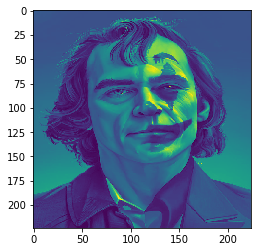

In [6]:
plt.imshow(X[1])

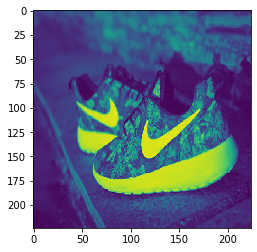

In [7]:
plt.imshow(X[47])

#### Reshape the data

In [8]:
X.shape

(80, 224, 224)

In [9]:
X = np.array(X).reshape((80, 224*224))

In [10]:
X.shape

(80, 50176)

#### Split the data

In [11]:
# split the dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(X,Y, test_size = 0.2, random_state = 3)

In [12]:
x_train.shape

(64, 50176)

In [13]:
x_test.shape

(16, 50176)

In [14]:
#from sklearn.preprocessing import StandardScaler
#sc_x = StandardScaler()
#x_train = sc_x.fit_transform(x_train)
#x_test = sc_x.transform(x_test)

### Reducing the dimension of the Images

In [15]:
# Application of PCA
from sklearn.decomposition import PCA
pca = PCA()  #kernel ='rbf' # this takes the indpendent variables that interpret the dataset the best.

In [16]:
x_train_check = pca.fit(x_train)  #x_train_check = pca.fit_transform(x_train) 

In [17]:
explained_variance = pca.explained_variance_ratio_
explained_variance # this was used to know how many components the PCA would explain "the most the variance".


array([3.48576628e-01, 7.96200836e-02, 7.21341377e-02, 4.93873522e-02,
       4.11774363e-02, 2.76206436e-02, 2.63933161e-02, 2.51215191e-02,
       2.26197939e-02, 1.99725239e-02, 1.72138692e-02, 1.63714596e-02,
       1.56972453e-02, 1.43486901e-02, 1.32807761e-02, 1.18980070e-02,
       1.14137249e-02, 1.08530236e-02, 1.03172810e-02, 9.56782109e-03,
       8.96810255e-03, 8.13597589e-03, 7.79797319e-03, 7.57300495e-03,
       7.26254314e-03, 6.57303955e-03, 6.33976049e-03, 6.21969202e-03,
       6.11188103e-03, 5.84754548e-03, 5.55645906e-03, 5.26667921e-03,
       5.08566347e-03, 4.75439883e-03, 4.51239201e-03, 4.45463657e-03,
       4.11611685e-03, 4.03612233e-03, 3.77110383e-03, 3.69241834e-03,
       3.51672953e-03, 3.31376242e-03, 3.10284545e-03, 2.72760646e-03,
       2.62574143e-03, 2.46319051e-03, 2.40796920e-03, 2.29300321e-03,
       2.23641113e-03, 1.99398916e-03, 1.84748094e-03, 1.68681110e-03,
       1.55481780e-03, 1.47321259e-03, 1.41054620e-03, 1.20214218e-03,
      

In [18]:
cumsum = np.cumsum(explained_variance) # find the cummulative summation of that array
cumsum

array([0.34857663, 0.42819671, 0.50033085, 0.5497182 , 0.59089564,
       0.61851628, 0.6449096 , 0.67003112, 0.69265091, 0.71262343,
       0.7298373 , 0.74620876, 0.76190601, 0.7762547 , 0.78953547,
       0.80143348, 0.81284721, 0.82370023, 0.83401751, 0.84358533,
       0.85255343, 0.86068941, 0.86848738, 0.87606039, 0.88332293,
       0.88989597, 0.89623573, 0.90245542, 0.9085673 , 0.91441485,
       0.91997131, 0.92523799, 0.93032365, 0.93507805, 0.93959044,
       0.94404508, 0.9481612 , 0.95219732, 0.95596842, 0.95966084,
       0.96317757, 0.96649133, 0.96959418, 0.97232178, 0.97494753,
       0.97741072, 0.97981869, 0.98211169, 0.9843481 , 0.98634209,
       0.98818957, 0.98987638, 0.9914312 , 0.99290441, 0.99431496,
       0.9955171 , 0.99655435, 0.9974394 , 0.99825996, 0.99891484,
       0.99943954, 0.99978311, 1.        , 1.        ])

In [19]:
n_comp = np.argmax(cumsum >= 0.96) + 1 # return the indices in the cumsum with a value greater than 0.96 ... this value is 40( this is 6
# because of pythons indexing, then add plus 1: 41. 

In [20]:
n_comp

41

In [21]:
pca = PCA(n_components = n_comp)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

In [22]:
# Basically the eigen faces are the vectors that best represent the large image matrices

In [23]:
eigenfaces = pca.components_.reshape((n_comp, 224, 224))

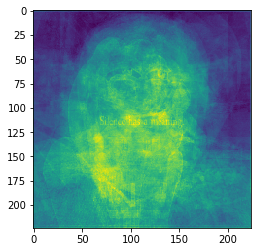

In [24]:
plt.imshow(eigenfaces[0])

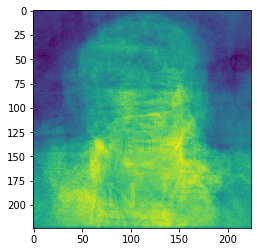

In [25]:
plt.imshow(eigenfaces[1])

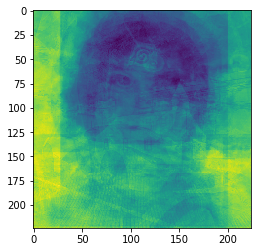

In [26]:
plt.imshow(eigenfaces[2])

In [27]:
# let us convert back to the original images from the compressed format.
X_recover = pca.inverse_transform(x_train)
X_recover= X_recover.reshape((64,224,224))

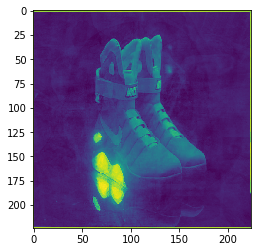

In [28]:
plt.imshow(X_recover[0])

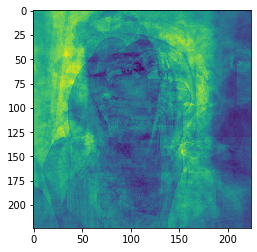

In [29]:
plt.imshow(X_recover[1])

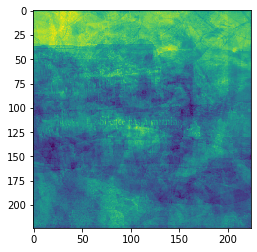

In [30]:
plt.imshow(X_recover[2])

#### Classifying using Support Vector Machines

In [31]:
from sklearn.svm import SVC
Fclassifier = SVC()
#Fclassifier.fit(x_train, y_train)

In [32]:
from sklearn.model_selection import GridSearchCV
parameters = [{'C' : [1,100,1000], 'kernel':['linear']},
              {'C' : [1,100,1000], 'kernel':['rbf'], 'gamma':[0.5,0.1, 0.01,0.001,0.0001]}]

grid_search = GridSearchCV(estimator = Fclassifier, 
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 10,
                           n_jobs =-1)
grid_search = grid_search.fit(x_train, y_train)

In [33]:
best_accuracy = grid_search.best_score_
best_accuracy * 100 # Multiplied by 100 to get in percentage 

51.42857142857142

In [34]:
best_parameters = grid_search.best_params_
best_parameters

{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}

In [35]:
Fclassifier = grid_search.best_estimator_
Fclassifier.fit(x_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.5, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [36]:
y_pred = Fclassifier.predict(x_test)

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cn = confusion_matrix(y_test, y_pred)

In [38]:
print(cn)

[[0 9]
 [0 7]]


In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.44      1.00      0.61         7

    accuracy                           0.44        16
   macro avg       0.22      0.50      0.30        16
weighted avg       0.19      0.44      0.27        16



C:\Users\Kenechi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [40]:
print(accuracy_score(y_pred, y_test) * 100)

43.75


In [41]:
# analysis

In [42]:
# What does the x_test look like?
x_test

array([[-7.55224723e+03,  7.84742448e+00, -5.69564807e+03,
         2.52898961e+03,  6.38994614e+03, -2.77136477e+02,
         2.12462684e+03, -9.30207235e+02, -2.68918191e+03,
        -3.33037000e+02,  3.02492399e+00, -8.77082429e+02,
         6.49591899e+02, -9.78617325e+02,  1.68527188e+03,
         8.34186247e+02, -6.44682075e+02, -9.79119151e+02,
         8.63100626e+02,  1.36288976e+03,  7.64426909e+02,
         4.51427457e+02, -2.67659721e+02, -2.35231753e+02,
         3.06544960e+02,  2.36122665e+02, -9.88557570e+02,
        -6.31165243e+02,  1.58759320e+03,  5.25223598e+01,
        -5.86945102e+00, -2.28163036e+01,  3.46886166e+02,
        -3.56665450e+01, -9.00542316e+02, -4.29239899e+02,
         1.09087355e+03, -7.32171821e+02,  1.16692569e+03,
        -2.19716425e+02, -4.06817733e+02],
       [-6.16386085e+03, -1.10737876e+03, -3.64093982e+03,
        -1.75539305e+03, -4.84612014e+03, -3.61837675e+02,
         9.62732314e+02, -3.04260099e+03,  1.32622425e+03,
         1.14

In [43]:
x_test.shape

(16, 41)

In [44]:
test_recover = pca.inverse_transform(x_test)

In [45]:
test_recover = test_recover.reshape((16,224,224))

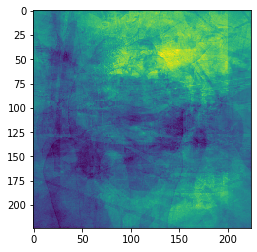

In [46]:
plt.imshow(test_recover[0])

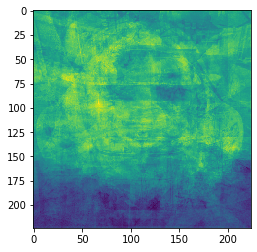

In [47]:
plt.imshow(test_recover[1])

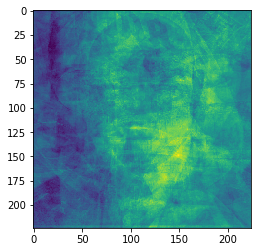

In [48]:
plt.imshow(test_recover[2])

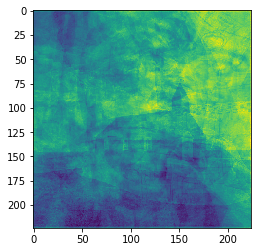

In [49]:
plt.imshow(test_recover[3])

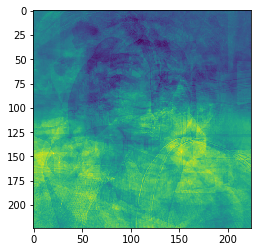

In [50]:
plt.imshow(test_recover[4])

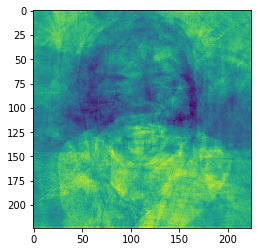

In [51]:
plt.imshow(test_recover[5])

In [52]:
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [53]:
print(y_test)

[0 0 0 1 0 1 1 0 1 0 1 1 1 0 0 0]


# SECOND TASK: IDENTIFY WHO IS IN THE IMAGE

In [54]:
# image dataset path
dataset = 'whoisthis/'

In [55]:
name_file = pd.read_csv('name_tags.csv')

In [56]:
name_file.head()

,image_name,tags
0,train_1,Beyonce
1,train_2,Beyonce
2,train_3,Beyonce
3,train_4,Beyonce
4,train_5,Beyonce


In [57]:
name_file.shape

(150, 2)

In [58]:
def names(name_file):
    name_tag= dict()
    for i in range(len(name_file)):
        name, tags = name_file["image_name"][i], name_file['tags'][i]
        name_tag[name] = tags
    return(name_tag)


In [59]:
see = names(name_file)

In [60]:
see


{'train_1': 'Beyonce',
 'train_2': 'Beyonce',
 'train_3': 'Beyonce',
 'train_4': 'Beyonce',
 'train_5': 'Beyonce',
 'train_6': 'Beyonce',
 'train_7': 'Beyonce',
 'train_8': 'Beyonce',
 'train_9': 'Beyonce',
 'train_10': 'Beyonce',
 'train_11': 'Rihanna',
 'train_12': 'Rihanna',
 'train_13': 'Rihanna',
 'train_14': 'Rihanna',
 'train_15': 'Rihanna',
 'train_16': 'Rihanna',
 'train_17': 'Rihanna',
 'train_18': 'Rihanna',
 'train_19': 'Rihanna',
 'train_20': 'Rihanna',
 'train_21': 'The Weeknd',
 'train_22': 'The Weeknd',
 'train_23': 'The Weeknd',
 'train_24': 'The Weeknd',
 'train_25': 'The Weeknd',
 'train_26': 'The Weeknd',
 'train_27': 'The Weeknd',
 'train_28': 'The Weeknd',
 'train_29': 'The Weeknd',
 'train_30': 'The Weeknd',
 'train_31': 'Drake',
 'train_32': 'Drake',
 'train_33': 'Drake',
 'train_34': 'Drake',
 'train_35': 'Drake',
 'train_36': 'Drake',
 'train_37': 'Drake',
 'train_38': 'Drake',
 'train_39': 'Drake',
 'train_40': 'Drake',
 'train_41': 'Meg The Stallion',
 'trai

In [61]:
def load_images_targets(directory, name_file):
    #train_pictures = list()
    targets = list()
    gray_scaled = list()
    name_targ = names(name_file)
    images = pd.DataFrame()
    print('Converting to numpy array ...')
    for picture in listdir(directory) :
         if picture != 'Thumbs.db':
                 # load the picture from directory
                photo = load_img(directory + picture, target_size = (224,224))
                
                #convert image to numpy array
                photo = img_to_array(photo, dtype='uint8')  
                
                #photo = photo.reshape(1, 224, 224, 3)
                
                # append to list
                #train_pictures.append(photo)
                
                # convert image to grayscale
                gray_scale = cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY)
                gray_scaled.append(gray_scale)
                
                # label targets
                targets.append(name_targ[picture.split('.')[0]])

    print(' ')
    
    X_TRAIN = asarray(gray_scaled, dtype = 'uint8')
    Y_TRAIN = asarray(targets)#, dtype = 'uint8')
    print(' ')
    print('Done!')
    return X_TRAIN, Y_TRAIN #images

In [62]:
X,Y = load_images_targets(dataset, name_file)

Converting to numpy array ...
 
 
Done!


#### RESHAPE THE DATA

In [63]:
X.shape

(150, 224, 224)

In [64]:
X = np.array(X).reshape((150, 224*224))

In [65]:
X.shape

(150, 50176)

#### SPLIT THE DATA

In [66]:
# split the dataset
from sklearn.model_selection import train_test_split
x_train, x_test, y_train,y_test = train_test_split(X,Y, test_size = 0.2, random_state = 3)

In [67]:
x_train.shape

(120, 50176)

In [68]:
x_test.shape

(30, 50176)

In [69]:
#### REDUCING THE DIMENSION OF THE IMAGES

In [70]:
# Application of PCA
from sklearn.decomposition import PCA
pca = PCA()  #kernel ='rbf' # this takes the indpendent variables that interpret the dataset the best.

In [71]:
x_train_check = pca.fit(x_train)

In [72]:
explained_variance = pca.explained_variance_ratio_
explained_variance # this was used to know how many components the PCA would explain "the most the variance".


array([3.80406378e-01, 6.79643590e-02, 5.80318999e-02, 4.56606818e-02,
       3.10665052e-02, 2.50453698e-02, 2.44883854e-02, 2.24456953e-02,
       1.95687589e-02, 1.70542043e-02, 1.58201647e-02, 1.31555954e-02,
       1.19012627e-02, 1.16206382e-02, 1.07905496e-02, 9.58492994e-03,
       8.76035441e-03, 8.07539369e-03, 7.96550831e-03, 7.82057520e-03,
       6.92267054e-03, 6.82265620e-03, 6.52468187e-03, 6.20843777e-03,
       5.94658627e-03, 5.59829540e-03, 5.44475988e-03, 4.97355417e-03,
       4.87660792e-03, 4.41753467e-03, 4.25696418e-03, 4.10694612e-03,
       3.98883888e-03, 3.89535442e-03, 3.72176255e-03, 3.54143491e-03,
       3.45622659e-03, 3.37467261e-03, 3.23644472e-03, 3.15381992e-03,
       2.99738507e-03, 2.98180088e-03, 2.95578989e-03, 2.74467216e-03,
       2.71492206e-03, 2.68002681e-03, 2.61832560e-03, 2.56918193e-03,
       2.45858418e-03, 2.41645784e-03, 2.29438854e-03, 2.28120296e-03,
       2.25357165e-03, 2.20181426e-03, 2.14638739e-03, 2.10934712e-03,
      

In [73]:
cumsum1 = np.cumsum(explained_variance) # find the cummulative summation of that array
cumsum1

array([0.38040638, 0.44837074, 0.50640264, 0.55206332, 0.58312982,
       0.60817519, 0.63266358, 0.65510927, 0.67467803, 0.69173224,
       0.7075524 , 0.720708  , 0.73260926, 0.7442299 , 0.75502045,
       0.76460538, 0.77336573, 0.78144113, 0.78940663, 0.79722721,
       0.80414988, 0.81097254, 0.81749722, 0.82370566, 0.82965224,
       0.83525054, 0.8406953 , 0.84566885, 0.85054546, 0.85496299,
       0.85921996, 0.8633269 , 0.86731574, 0.8712111 , 0.87493286,
       0.8784743 , 0.88193052, 0.88530519, 0.88854164, 0.89169546,
       0.89469284, 0.89767465, 0.90063044, 0.90337511, 0.90609003,
       0.90877006, 0.91138838, 0.91395756, 0.91641615, 0.91883261,
       0.92112699, 0.9234082 , 0.92566177, 0.92786358, 0.93000997,
       0.93211932, 0.93417148, 0.93618937, 0.93815587, 0.94008037,
       0.94199516, 0.94383696, 0.94565762, 0.94743366, 0.94913814,
       0.95081556, 0.95249022, 0.95411616, 0.95572445, 0.95731742,
       0.95883753, 0.9603287 , 0.96180996, 0.96325019, 0.96466

In [74]:
n_comp = np.argmax(cumsum1 >= 0.99) + 1 

In [75]:
n_comp

99

In [76]:
pca1= PCA(n_components = n_comp)
x_train = pca1.fit_transform(x_train)
x_test = pca1.transform(x_test)

In [77]:
eigenfaces = pca1.components_.reshape((n_comp, 224, 224))

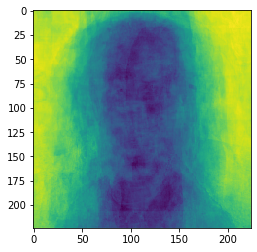

In [78]:
plt.imshow(eigenfaces[0])

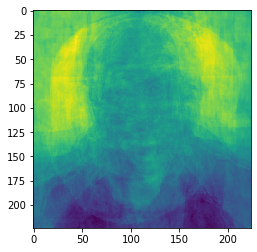

In [79]:
plt.imshow(eigenfaces[1])

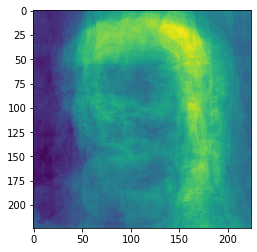

In [80]:
plt.imshow(eigenfaces[2])

In [81]:
# let us convert back to the original images from the compressed format.
X_recover = pca1.inverse_transform(x_train)
X_recover= X_recover.reshape((120,224,224))

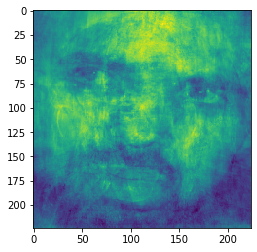

In [82]:
plt.imshow(X_recover[0])

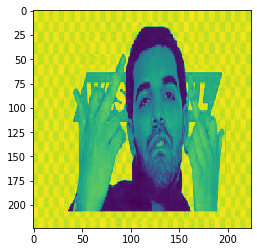

In [83]:
plt.imshow(X_recover[1])

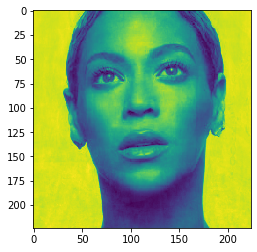

In [84]:
plt.imshow(X_recover[2])

#### CLASSIFYING USING SUPPORT VECTOR MACHINES

In [85]:
from sklearn.svm import SVC
Wclassifier = SVC(class_weight='balanced')

In [86]:
from sklearn.model_selection import GridSearchCV
parameters =   [{'C' : [1,100,1000], 'kernel':['linear']},
              {'C' : [1,100,1000], 'kernel':['rbf'], 'gamma':[0.5,0.1, 0.01,0.001,0.0001]}]

             

grid_search = GridSearchCV(estimator = Wclassifier, 
                           param_grid = parameters,
                           scoring = 'accuracy',
                           cv = 6,
                           n_jobs =-1)
grid_search = grid_search.fit(x_train, y_train)

In [87]:
best_accuracy = grid_search.best_score_
best_accuracy * 100 # Multiplied by 100 to get in percentage 

46.666666666666664

In [88]:
best_parameters = grid_search.best_params_
best_parameters

{'C': 1, 'kernel': 'linear'}

In [89]:
Wclassifier = grid_search.best_estimator_
Wclassifier.fit(x_train, y_train)

SVC(C=1, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [90]:
y_pred = Wclassifier.predict(x_test)

In [91]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
cn = confusion_matrix(y_test, y_pred)

In [92]:
print(cn)

[[3 1 0 1 0]
 [2 2 0 0 0]
 [4 2 3 1 0]
 [1 2 0 0 1]
 [3 2 1 0 1]]


In [93]:
print(classification_report(y_test, y_pred))

                  precision    recall  f1-score   support

         Beyonce       0.23      0.60      0.33         5
           Drake       0.22      0.50      0.31         4
Meg The Stallion       0.75      0.30      0.43        10
         Rihanna       0.00      0.00      0.00         4
      The Weeknd       0.50      0.14      0.22         7

        accuracy                           0.30        30
       macro avg       0.34      0.31      0.26        30
    weighted avg       0.43      0.30      0.29        30



In [94]:
print(accuracy_score(y_pred, y_test) * 100)

30.0


In [95]:
zipped = zip(y_pred, y_test)
print(f'Predicted: | Actual:')
for l1,l2 in zipped:
    print(f'- {l1} | {l2} ')
   

Predicted: | Actual:
- Drake | Meg The Stallion 
- The Weeknd | The Weeknd 
- Beyonce | Drake 
- Drake | Drake 
- Drake | Drake 
- Beyonce | Beyonce 
- Beyonce | Meg The Stallion 
- Drake | The Weeknd 
- Rihanna | Beyonce 
- Beyonce | The Weeknd 
- Meg The Stallion | Meg The Stallion 
- Beyonce | Meg The Stallion 
- Drake | Meg The Stallion 
- Rihanna | Meg The Stallion 
- Drake | Rihanna 
- Beyonce | Meg The Stallion 
- Beyonce | The Weeknd 
- Beyonce | Rihanna 
- Drake | Beyonce 
- Beyonce | Meg The Stallion 
- Drake | Rihanna 
- Beyonce | Beyonce 
- Drake | The Weeknd 
- Beyonce | Drake 
- Beyonce | The Weeknd 
- Beyonce | Beyonce 
- The Weeknd | Rihanna 
- Meg The Stallion | The Weeknd 
- Meg The Stallion | Meg The Stallion 
- Meg The Stallion | Meg The Stallion 


###### REFERENCES

In [96]:
# * : means I referrenced these materials more.

# * https://www.kaggle.com/hamishdickson/preprocessing-images-with-dimensionality-reduction
# https://shankarmsy.github.io/posts/pca-sklearn.html
# * https://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html